Importando bibliotecas necessárias

In [1]:
!pip install xgboost
!pip -q install shap


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split,  StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, classification_report, recall_score, f1_score
from collections import Counter
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

Carregando dados


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Dados de Treino: {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Dados de Teste: {test.shape[0]} linhas e {test.shape[1]} colunas")

Dados de Treino: 227845 linhas e 32 colunas
Dados de Teste: 56962 linhas e 31 colunas


In [ ]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,265519,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0
1,180306,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0
2,42665,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0
3,198724,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0
4,82326,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0


Análise Exploratória dos Dados (EDA)

In [ ]:
print("INFORMAÇÕES DO DATASET DE TREINO\n")
train.info()

INFORMAÇÕES DO DATASET DE TREINO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      227845 non-null  int64  
 1   Time    227845 non-null  float64
 2   V1      227845 non-null  float64
 3   V2      227845 non-null  float64
 4   V3      227845 non-null  float64
 5   V4      227845 non-null  float64
 6   V5      227845 non-null  float64
 7   V6      227845 non-null  float64
 8   V7      227845 non-null  float64
 9   V8      227845 non-null  float64
 10  V9      227845 non-null  float64
 11  V10     227845 non-null  float64
 12  V11     227845 non-null  float64
 13  V12     227845 non-null  float64
 14  V13     227845 non-null  float64
 15  V14     227845 non-null  float64
 16  V15     227845 non-null  float64
 17  V16     227845 non-null  float64
 18  V17     227845 non-null  float64
 19  V18     227845 non-null  float64
 20  V19     227845

In [ ]:
# Verificando valores nulos
print("\nValores Nulos no Dataset de Treino:\n")
print(train.isnull().sum())


Valores Nulos no Dataset de Treino:

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
#verificando o desbalanceamento entre fraude e n_fraude
print("Proporção original de classes:")
print(train["Class"].value_counts(normalize=True)*100)

Proporção original de classes:
Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64


Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64


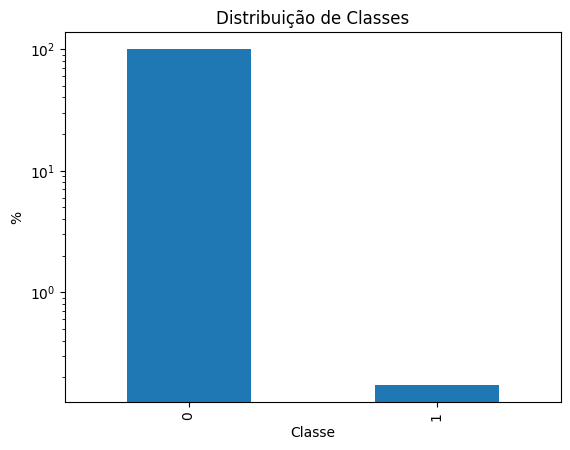

In [ ]:
#gráfico do desbalanceamento
percent = train["Class"].value_counts(normalize=True)*100
print(percent)

percent.plot(kind="bar")
plt.yscale("log")
plt.title("Distribuição de Classes")
plt.xlabel("Classe")
plt.ylabel("%")
plt.show()

Preparação dos Dados (Feature Engineering)

In [5]:
# todas as variáveis são numéricas e não há dados nulos, então não é necessário tratar nem converter os valores
# é necessário separar as variáveis explicáveis (X) e a variável que queremos prever (Y), no caso "Class"

x = train.drop(["Class", "id"], axis = 1) # axis = 1 remove colunas
y = train["Class"]

print(x.shape, y.shape)

(227845, 30) (227845,)


Tratamento de desbalanceamento

In [6]:
#Split train/val
#separa X e y para treino, X e y para validação
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size = 0.2, #20% para validação
    stratify = y, #mantém a proporção fraude/n_fraude
    random_state = 42
)
print(f"Dados de Treino: {x_train.shape[0]} amostras\n")
print(f"Dados de Validação: {x_val.shape[0]} amostras")

Dados de Treino: 182276 amostras

Dados de Validação: 45569 amostras


In [7]:
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 577.6539682539683


Treinamento do modelo XGBoost (Desenvolvimento / validação)

In [8]:
# definir hiperparâmetros
xgb_params = dict(
    n_estimators=3000,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="auc"
)


Validação cruzada no treino

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_scores = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(x_train, y_train), start=1):

    x_tr = x_train.iloc[tr_idx]
    x_va = x_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]

    model = XGBClassifier(**xgb_params)
    model.fit(x_tr, y_tr)

    prob = model.predict_proba(x_va)[:, 1]
    roc = roc_auc_score(y_va, prob)
    roc_scores.append(roc)

    print(f"Fold {fold} ROC-AUC: {roc:.6f}")

roc_scores = np.array(roc_scores)

print("\nROC-AUC médio:", roc_scores.mean())
print("Desvio padrão:", roc_scores.std())

Fold 1 ROC-AUC: 0.994529
Fold 2 ROC-AUC: 0.975695
Fold 3 ROC-AUC: 0.991609
Fold 4 ROC-AUC: 0.976152
Fold 5 ROC-AUC: 0.990533

ROC-AUC médio: 0.9857037605231282
Desvio padrão: 0.008092984048780852


Treino

In [10]:
xgb = XGBClassifier(**xgb_params)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [11]:
prob_val = xgb.predict_proba(x_val)[:, 1]


threshold = 0.44
pred_val = (prob_val >= threshold).astype(int)

roc = roc_auc_score(y_val, prob_val)

rec = recall_score(y_val, pred_val)
f1 = f1_score(y_val, pred_val)

print("ROC-AUC (hold-out):", roc)

print("\nClassification report:\n", classification_report(y_val, pred_val))

ROC-AUC (hold-out): 0.9770955363677091

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.85      0.80      0.82        79

    accuracy                           1.00     45569
   macro avg       0.93      0.90      0.91     45569
weighted avg       1.00      1.00      1.00     45569



Curva ROC

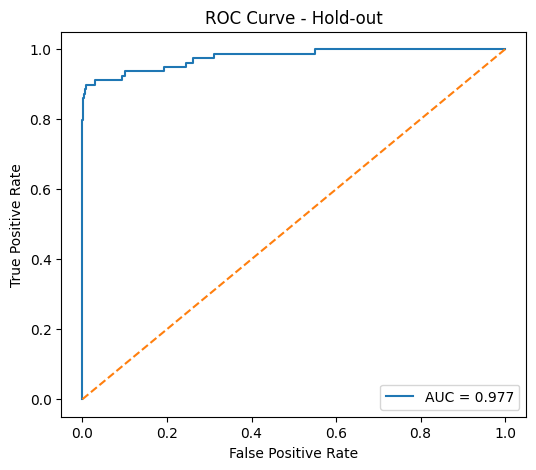

In [12]:
fpr, tpr, _ = roc_curve(y_val, prob_val)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hold-out")
plt.legend()
plt.show()



Treinando o modelo final (produção/submissão)

In [31]:
final_model = XGBClassifier(
    n_estimators=3000,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="auc")

final_model.fit(x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3000,
              n_jobs=-1, num_parallel_tree=None, ...)

Interpretabilidade do modelo SHAP (global + local)


In [14]:
x_sample = x_train.sample(2000, random_state=42)
print(x_sample.shape)

(2000, 30)


In [15]:
explainer = shap.TreeExplainer(xgb)

shap_values = explainer.shap_values(x_sample)

print(np.array(shap_values).shape)

(2000, 30)


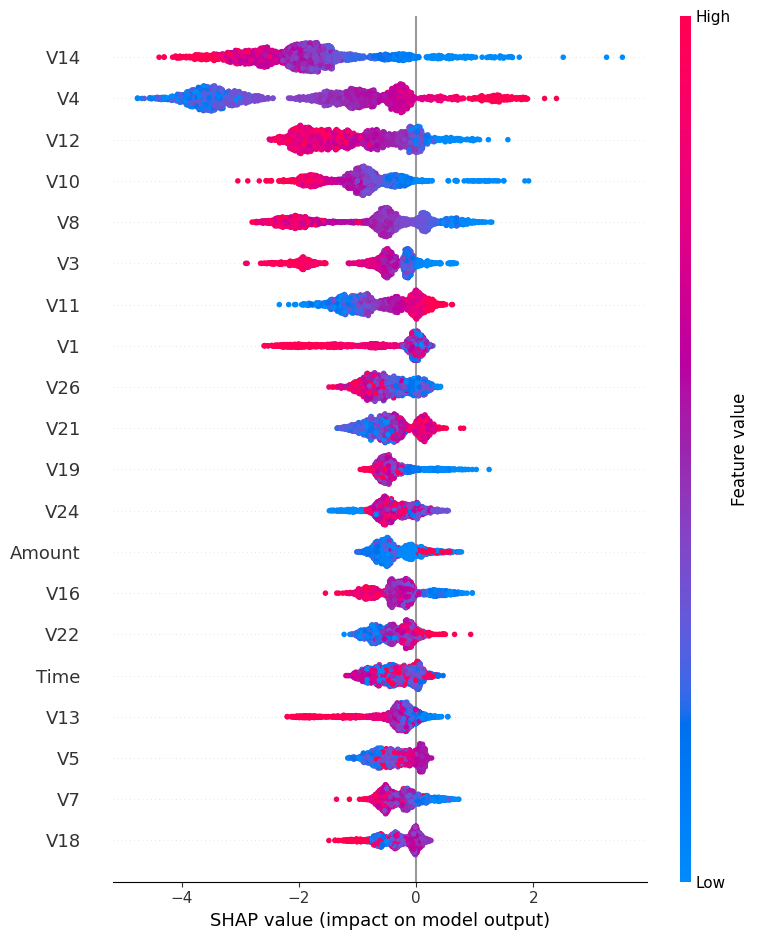

In [16]:
shap.summary_plot(shap_values, x_sample)


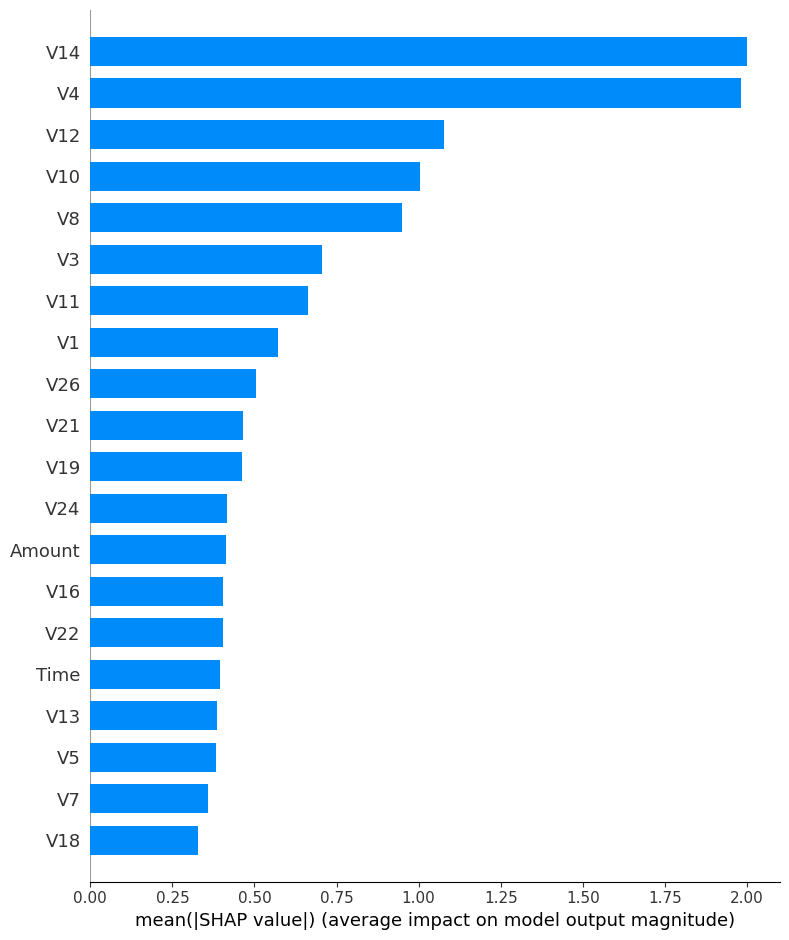

In [17]:
shap.summary_plot(shap_values, x_sample, plot_type="bar", show = False)

In [18]:
probs = xgb.predict_proba(x_sample)[:, 1]
idx = np.argmax(probs)
print("Maior probabilidade na amostra:", probs[idx])
print("Índice escolhido:", idx)

Maior probabilidade na amostra: 0.9999287
Índice escolhido: 987


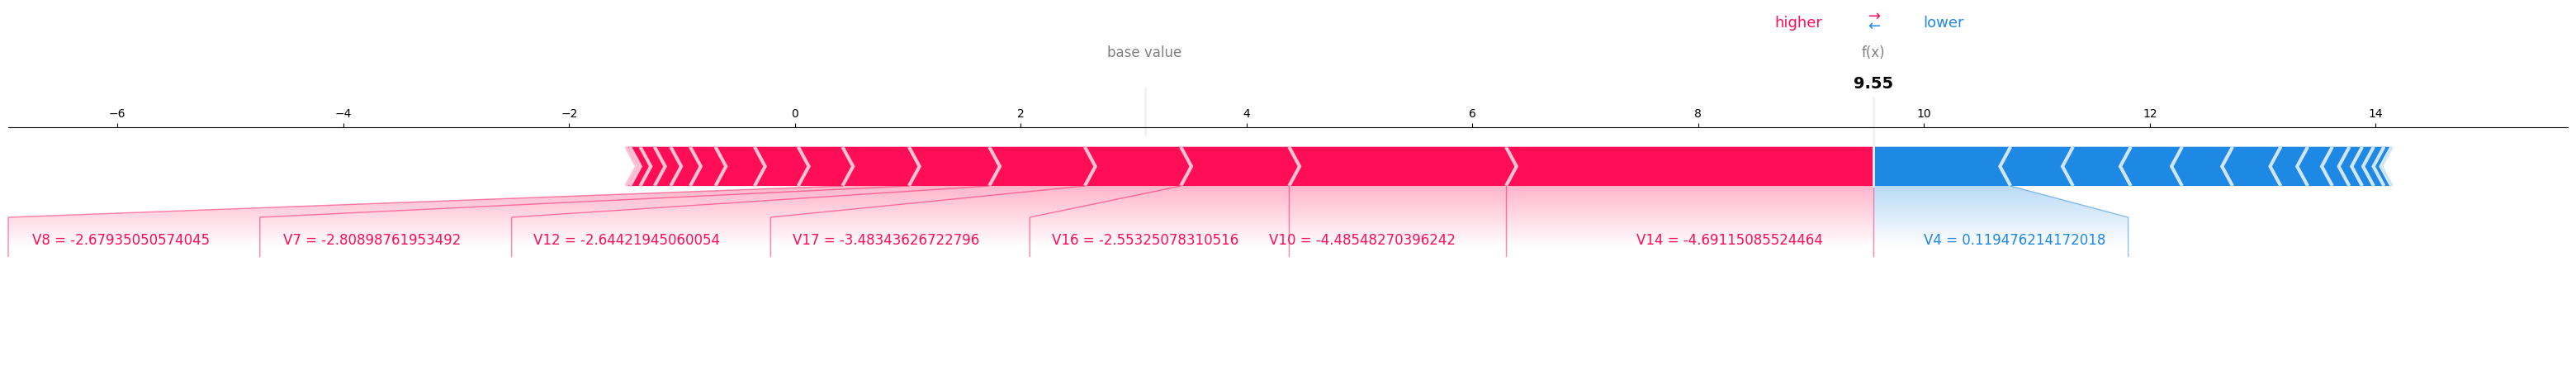

In [25]:
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    x_sample.iloc[idx],
    matplotlib=True,
    figsize = (40,4)
)
plt.show()


Permutation Importance

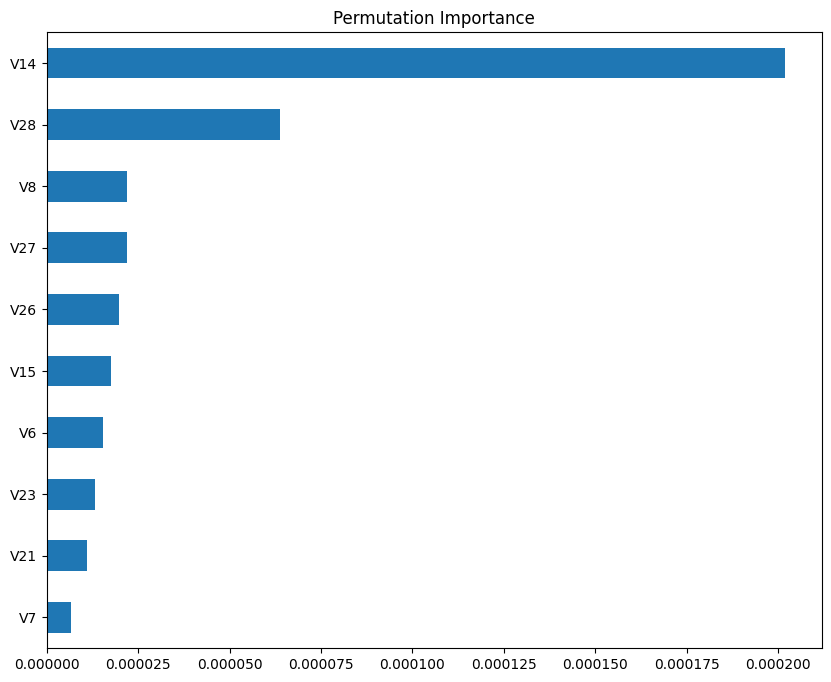

In [27]:
result = permutation_importance(
    xgb,
    x_val,
    y_val,
    n_repeats = 10,
    random_state = 42,
    n_jobs = -1
)
plt.figure(figsize=(10, 8))
feat_imp = pd.Series(result.importances_mean, index = x_val.columns)
feat_imp.sort_values().tail(10).plot(kind="barh")
plt.title("Permutation Importance")
plt.show()



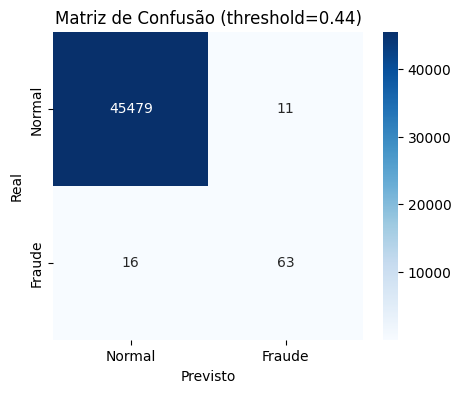

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, pred_val)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Fraude"],
            yticklabels=["Normal","Fraude"])
plt.title(f"Matriz de Confusão (threshold={threshold})")
plt.xlabel("Previsto"); plt.ylabel("Real")
plt.show()




In [ ]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0.01, 0.5, 50)
best_t, best_f1 = 0, -1

for t in thresholds:
    pred = (prob_val >= t).astype(int)
    f1 = f1_score(y_val, pred)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Melhor threshold:", best_t, "Melhor F1:", best_f1)

Melhor threshold: 0.44 Melhor F1: 0.8235294117647058


Salvar o modelo

In [32]:
import os

os.makedirs("models", exist_ok=True)

In [33]:
import joblib
joblib.dump(final_model, "models/final_model.pkl")

os.listdir("models")
from google.colab import files
files.download("models/final_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submissão

In [51]:
x_test = test.drop('id', axis=1)

proba_test = final_model.predict_proba(x_test)[:, 1]

submission = pd.DataFrame({
    "id": test["id"],
    "target": proba_test
})

submission.to_csv("submission_final.csv", index=False)

submission.head()

,id,target
0,263021,8.547968e-06
1,11379,8.214957e-07
2,147284,3.818343e-05
3,219440,6.503111e-07
4,36940,1.522406e-03


Download

In [52]:
from google.colab import files
files.download("submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>